In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, shutil, sklearn

from modules import WineDb
from modules.PreprocessingFunctions import Functions as prep

if os.path.exists('modules\__pycache__'):
    shutil.rmtree('modules\__pycache__')

In [2]:
winedb = WineDb.WineDb()
winedb().head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


# Binary Classification

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Train/Test/Split and fit auxiliary functions
def get_split_data(input_db, excluded, target, test_size=0.33):
    excluded_col = excluded+target
    x = input_db.loc[:,input_db.columns.difference(excluded_col)]
    y = input_db.loc[:,target][target[0]]
    
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.4, random_state = 42)
    
    return x_train, x_test, y_train, y_test

def fit_and_test(args, model):
    x_train, x_test, y_train, y_test = args
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    return confusion_matrix(y_test, pred)

In [4]:
# Pipelines
def pipeline_class_1(x, excluded):
    output = prep.minmax_norm(x, excluded)
    return output

def pipeline_class_2(x, excluded):
    x = prep.zscore_outliers(x, 4, excluded)
    output = prep.minmax_norm(x, excluded)
    return output

def pipeline_class_3(x, excluded):
    x = prep.isoforest_outliers(x, excluded)
    x = prep.smote(x)
    output = prep.standard_norm(x, excluded)
    return output

def pipeline_class_4(x, excluded):
    x = prep.minmax_norm(x, excluded)
    output = prep.pca(x, excluded)
    return output

In [5]:
target_col = ['type']
excluded_col = ['alcohol', 'quality']

dbs = {
    'pipeline_1':pipeline_class_1(winedb(), target_col),
    'pipeline_2': pipeline_class_2(winedb(), target_col),
    'pipeline_3': pipeline_class_3(winedb(), target_col),
    'pipeline_4': pipeline_class_4(winedb(), target_col)
       }


Random Forest Results

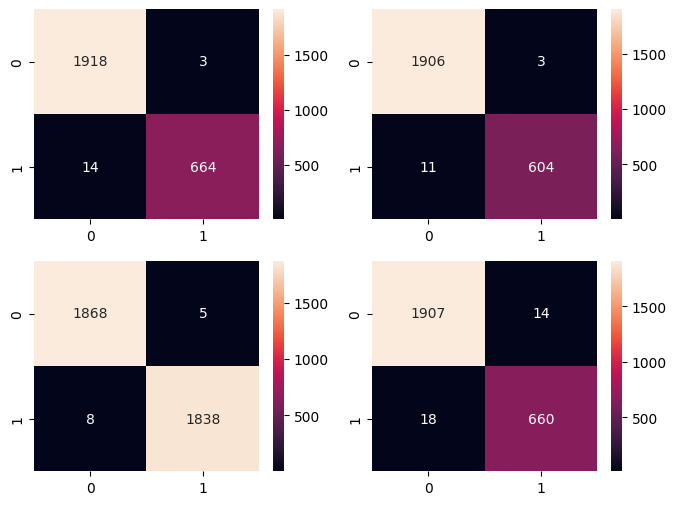

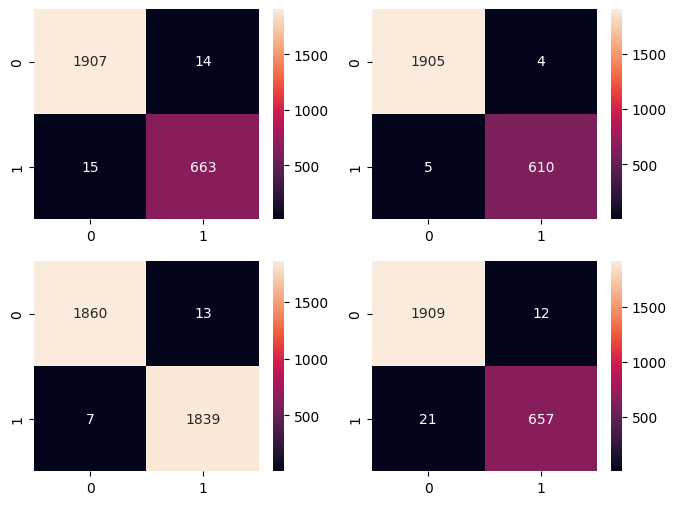

In [6]:
model_list = [RandomForestClassifier(), KNeighborsClassifier()]

for model in model_list:
    xind,yind = 0, 0
    f, ax = plt.subplots(2,2, figsize=(8, 6))
    for key in dbs:
        fig = sns.heatmap(fit_and_test(get_split_data(dbs[key], excluded_col, target_col), model), ax = ax[yind, xind],  annot=True,fmt="d")
        if xind < 1: 
            xind+=1
        else: 
            xind=0
            yind+=1
    
    f.savefig(f'plots/{model}_confusionmatrix')


KNN Results

# Regression (and SVM)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [8]:
# Pipelines
def pipeline_reg_1(x, excluded):
    output = prep.minmax_norm(x, excluded)
    return output

def pipeline_reg_2(x, excluded):
    x = prep.zscore_outliers(x, 4, excluded)
    output = prep.minmax_norm(x, excluded)
    return output

def pipeline_reg_3(x, excluded):
    x = prep.isoforest_outliers(x, excluded)
    x = prep.smote(x)
    output = prep.standard_norm(x, excluded)
    return output

def pipeline_reg_4(x, excluded):
    x = prep.minmax_norm(x, excluded)
    output = prep.pca(x, excluded)
    return output

In [9]:
target_col = ['quality']
excluded_col = ['type']

dbs = {
    'base': winedb(),
    'pipeline_1':pipeline_reg_1(winedb(), target_col),
    'pipeline_2': pipeline_reg_2(winedb(), target_col),
    'pipeline_3': pipeline_reg_3(winedb(), target_col),
    'pipeline_4': pipeline_reg_4(winedb(), target_col)
       }


In [10]:
def test_regressors(regressor, regressor_name, input_db, dbname):
    x_train, x_test, y_train, y_test = get_split_data(input_db, [], ['quality'])
    
    regressor.fit(x_train, y_train)
    preds = regressor.predict(x_test)
    cross_val_scores = cross_val_score(regressor, x_train, y_train, scoring="neg_mean_absolute_percentage_error")
    mse = mean_squared_error(y_test, preds)
    
    return({'name':regressor_name.upper(),
            'pipeline':dbname, 
            'score':regressor.score(x_test, y_test), 
            'avg_cross_val_score':sum(cross_val_scores)/len(cross_val_scores), 
            'mse':mse})

In [12]:
regressors = {'linear':LinearRegression(),
              'BayesianRidge':BayesianRidge(),
              'SVM_rbf':SVR(kernel='rbf'),
              'adaboost':AdaBoostRegressor()}

res = []

for dbname in dbs:
    for modelname in regressors:
        res.append(test_regressors(regressors[modelname], modelname, dbs[dbname], dbname))
    
res = pd.DataFrame(res)

In [15]:
res

,name,pipeline,score,avg_cross_val_score,mse
0,LINEAR,pipeline_1,0.280279,-0.100565,0.540076
1,BAYESIANRIDGE,pipeline_1,0.280475,-0.100578,0.539929
2,SVM_RBF,pipeline_1,0.352833,-0.093854,0.485632
3,ADABOOST,pipeline_1,0.282555,-0.105744,0.538368
4,LINEAR,pipeline_2,0.325753,-0.101495,0.508303
5,BAYESIANRIDGE,pipeline_2,0.325532,-0.101532,0.508470
6,SVM_RBF,pipeline_2,0.400271,-0.092272,0.452125
7,ADABOOST,pipeline_2,0.314793,-0.103484,0.516566
8,LINEAR,pipeline_3,0.346500,-0.090833,0.431019
9,BAYESIANRIDGE,pipeline_3,0.346490,-0.090833,0.431026
